In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

## looking at the data

In [4]:
train_df = pd.read_csv("training.csv")
valid_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

In [5]:
new_df = pd.concat([train_df , valid_df , test_df] , axis=0 )
# Reset the index
new_df = new_df.reset_index(drop=True)

In [6]:
new_df.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [14]:
new_df.one_hot_label.values

array([array([1, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 1, 0, 0]), ..., array([0, 1, 0, 0, 0, 0]),
       array([0, 1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0])], dtype=object)

In [8]:
new_df.isna().sum()

text     0
label    0
dtype: int64

In [9]:
for i in range (6):

    print(new_df[new_df["label"] == i].shape)

(5797, 2)
(6761, 2)
(1641, 2)
(2709, 2)
(2373, 2)
(719, 2)


In [10]:
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [11]:
def make_one_hot(index):
    label = np.zeros(6).astype(int)
    # label = [0,0,0,0,0,0]
    label[index] = 1
    return label

In [12]:
make_one_hot(4)

array([0, 0, 0, 0, 1, 0])

In [13]:
new_df["one_hot_label"] = new_df["label"].apply(make_one_hot)

In [15]:
from tensorflow.keras.layers import TextVectorization

MAX_FEATURES = 200000

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [16]:
vectorizer.adapt(new_df.text.values)

In [17]:
vectorized_text = vectorizer(new_df.text.values)
vectorized_text

<tf.Tensor: shape=(20000, 1800), dtype=int64, numpy=
array([[   2,  140,    3, ...,    0,    0,    0],
       [   2,   40,  102, ...,    0,    0,    0],
       [  16, 3360,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,    9, ...,    0,    0,    0],
       [  16,    8,   38, ...,    0,    0,    0],
       [   2,    3,   36, ...,    0,    0,    0]], dtype=int64)>

In [18]:
# tf.data.Dataset.from_tensor_slices(train_df["one_hot_label"].values[:3])
arr = np.stack(new_df["one_hot_label"].values[:3])
arr

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [19]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, np.stack(new_df["one_hot_label"].values)))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(tf.data.AUTOTUNE) # helps bottlenecks

In [20]:
dataset.as_numpy_iterator().next()

(array([[  2,   3,  49, ...,   0,   0,   0],
        [  2,   3,  38, ...,   0,   0,   0],
        [ 16,  26,   8, ...,   0,   0,   0],
        ...,
        [  2,  58,  28, ...,   0,   0,   0],
        [  2,  94, 480, ...,   0,   0,   0],
        [  2,   3, 378, ...,   0,   0,   0]], dtype=int64),
 array([[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]]))

In [21]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [23]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [24]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [53]:
history = model.fit(train, epochs=1, validation_data=val)

875/875 [==============================] - 1112s 1s/step - loss: 0.1371 - val_loss: 0.0990


<Figure size 800x500 with 0 Axes>

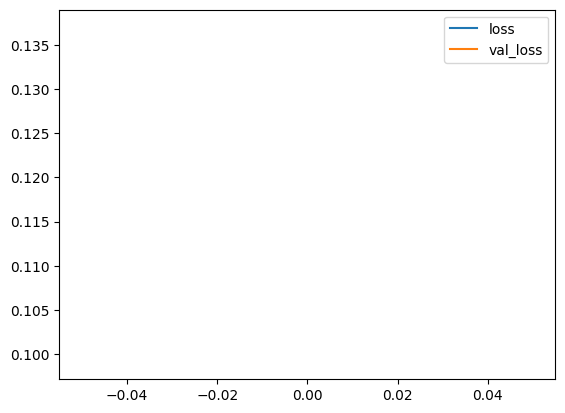

In [54]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [55]:
input = vectorizer("im not feeling so good , im a bit sad today ")


In [56]:
prediction = model.predict(tf.expand_dims(input , axis=0))
prediction

1/1 [==============================] - 0s 64ms/step


array([[0.28135386, 0.6382702 , 0.05822337, 0.00239211, 0.00391781,
        0.00538285]], dtype=float32)

In [57]:
(prediction > 0.5).astype(int)

array([[0, 1, 0, 0, 0, 0]])

In [58]:
y_pred = model.predict(test)

125/125 [==============================] - 20s 162ms/step


In [59]:
y_pred.shape

(2000, 6)

In [60]:
y_pred = (y_pred > 0.5).astype(int)

In [62]:
y_pred

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [41]:
# Unbatch the dataset to get individual elements
unbatched_dataset = test.unbatch()

y_true = []
# Iterate through all elements
for index, element in enumerate(unbatched_dataset):
    y_true.append(element[1].numpy())


In [42]:
y_true = np.array(y_true)
y_true = np.stack(y_true)

In [63]:
y_true

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [64]:
y_pred

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [183]:
# Assuming you have a tf.data.Dataset object called 'dataset'

# Define a lambda function to extract y values
get_y_value = lambda x, y: y

# Apply the lambda function to each element of the dataset
y_values_dataset = test.map(lambda x, y: get_y_value(x, y))

# Convert the dataset to a list to access all the y values
y_values = list(y_values_dataset.as_numpy_iterator())

f = 0
for i in range(1,17):
    s = y_values_dataset.as_numpy_iterator().next()
    print(s)
    f += 1

print(f)
# print(len(y_values))
# # Print the y values
# for y in y_values:
#     print(y)

[[0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
[[0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]]
[[0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]]
[[0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]]
[[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_true , y_pred))

              precision    recall  f1-score   support

           0       0.33      0.31      0.32       601
           1       0.34      0.36      0.35       648
           2       0.03      0.01      0.02       167
           3       0.13      0.15      0.14       269
           4       0.09      0.08      0.09       239
           5       0.00      0.00      0.00        76

   micro avg       0.26      0.24      0.25      2000
   macro avg       0.15      0.15      0.15      2000
weighted avg       0.24      0.24      0.24      2000
 samples avg       0.24      0.24      0.24      2000



c:\Users\Morvarid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Morvarid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
